# Прогнозирование вероятности оттока пользователей для фитнес-центров

## Описание проекта

Необходимо провести исследование поведения клиентов фитнес-центра, с целью вывявления факторов, позволяющих определить вероятность "оттока" клиентов, как минимум, за следующий месяц. 
Также, необходимо разработать модель, прогнозирующую "отток" клиентов на основе признаков поведения и провести кластеризацию по клиентам.
В результате проведенного исследования необходимо сформулировать выводы и дать рекомендации для повышения качества работы с клиентами.

## Описание данных

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Предобработка данных

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

In [3]:
# загрузим данные
gym_df = pd.read_csv('datasets/gym_churn.csv')

In [4]:
gym_df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
# переведем названия колонок в нижний регистр
gym_df.columns = gym_df.columns.str.lower()

In [6]:
# выведем общую информацию о датасете
# проверим на наличие пропусков в данных
gym_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Проверим датасет на наличие дублей.

In [28]:
gym_df.duplicated().sum()

0

### Выводы:

В датасете имеется 4000 строк. Пропусков в датасете нет. Типы данных соответствуют содержимому. Дубли отсутствуют.

## Исследовательский анализ (EDA)

In [7]:
# изучим статистические данные значений из датасета
gym_df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Исходя из полученных выше значений можно сделать следующие выводы:
- по половому признаку датасет распределен практически поровну
- как минимум 84% клиентов выбирают фитнес-центр поближе к дому или к работе
- около 48% клиентов являются сотрудниками компании-партнера клуба
- 30% клиентов были приглашены по акции "приведи друга"
- около 90% клиентов указали свой контактный телефонный номер
- как минимум у 50% клиентов срок абонемента составляет 1 месяц, а у 15% клиентов срок действия контракта составляет более 6-ти месяцев
- около 40% клиентов посещают групповые занятия
- средний возраст клиентов - 29 лет. Возраст половины клиентов из выборки находится в диапазоне от 27 до 31 года.
- в среднем суммарная выручка от других услуг фитнес-центра составляет 150 единиц
- в среднем до конца срока истечения абонентов у клиентов осталось чуть больше 4-х месяцев, при этом, как минимум, у 15% клиентов остаточный срок действия абонемента - не менее 6 месяцев
- средний lifetime составляет около 4-х месяцев. Лишь у 15% клиентов lifetime составляет более 5-ти месяцев.
- в среднем клиенты посещают зал примерно 2 раза в неделю, при этом сильных изменений нет в посещаемости за прошлый месяц, но количество посещений явно стало чуть меньше
- доля оттока составила около 26% 

Наиболее ярко степень изменчивости в значениях выражена у параметра `avg_additional_charges_total` у которого стандартное отклонение равно 96 при среднем значении в 146. Это указывает на то, что среди клиентов есть те кто очень мало платит (или практически не платит) за дополнительные услуги фитнес-центра и те, кто платит за доп.услуги очень много.

In [29]:
# изучим средние значения в разрезе параметра 'churn'
gym_df.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


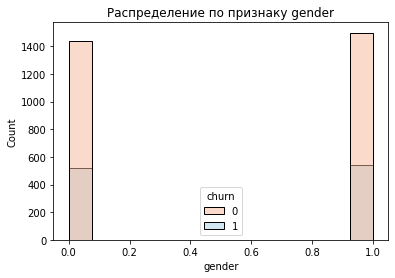

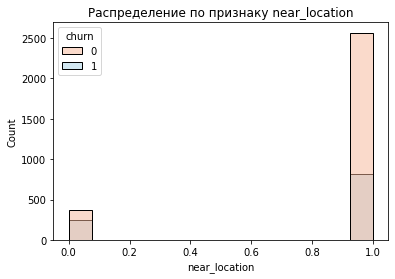

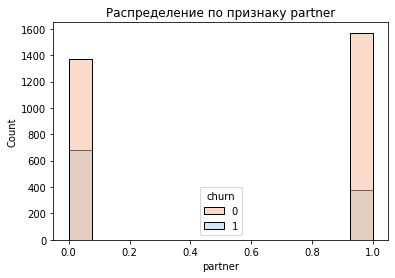

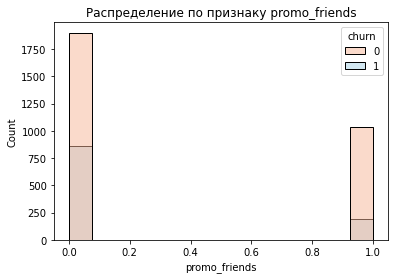

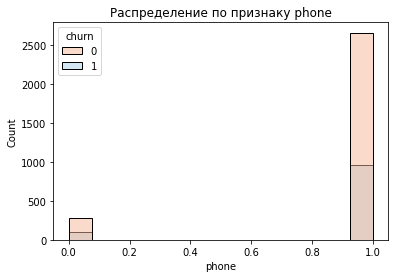

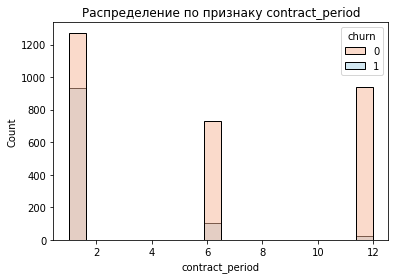

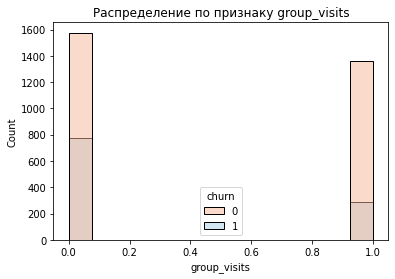

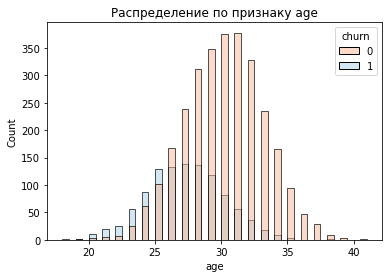

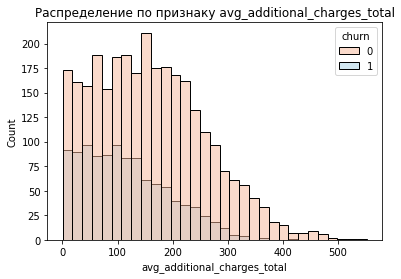

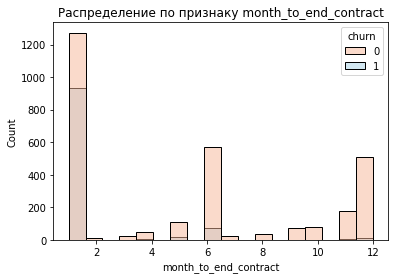

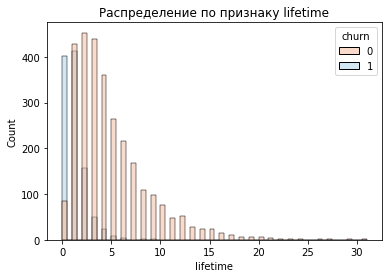

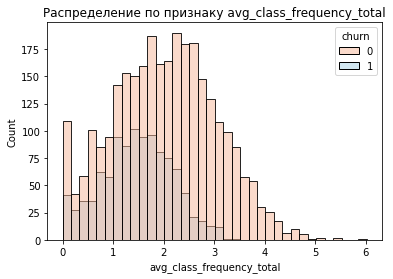

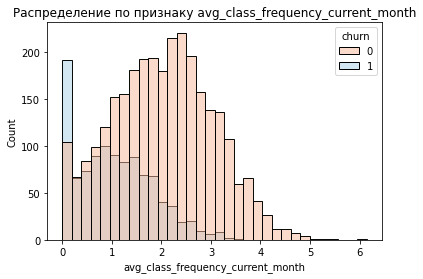

In [31]:
# построим гистограммы распределений значений для каждого параметра
for column in gym_df.columns:
    if column != 'churn':
        sns.histplot(data=gym_df[[column, 'churn']], x=column, hue='churn', palette='RdBu')
        plt.title('Распределение по признаку ' + column)
        plt.show()

- отток не сильно зависит от пола
- клиенты, выбирающие фитнес-центр не рядом с работой или домом более склонны к оттоку
- сотрудники компаний-партнеров менее склонны к оттоку
- клиенты, пришедшие по акции "приведи друга", тоже в наименьшей степени склонны к оттоку
- чем меньше срок действия абонемента, тем выше вероятность оттока клиента
- посещение групповых занятий не увеличивает вероятности оттока
- более склонны к оттокам клиенты помоложе (средний возраст - 26 лет), что может объясняться меньшей ответственностью и низкой мотивацией к посещению
- чем больше клиент оплачивает доп. услуг фитнес-центра, тем меньше вероятность оттока такого клиента
- в среднем больший отток заметен среди тех клиентов, у которых до конца срока действия абонемента осталось от 1 до 2-х месяцев
- для клиентов с высоким показателем lifetime вероятность оттока приближается к 0, в среднем отток клиентов происходит для клиентов с уровнем показателя lifetime ниже 10 месяцев
- чем меньшее количество раз клиент посещает фитнес-центр в неделю, тем больше вероятность его оттока
- если в прошлом месяце в среднем клиент ни разу не посетил фитнес-центр, то с большой долей вероятности мы можем быть уверенны в его оттоке

Построим ниже матрицу корреляции и визуализируем ее с помощью тепловой карты.

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


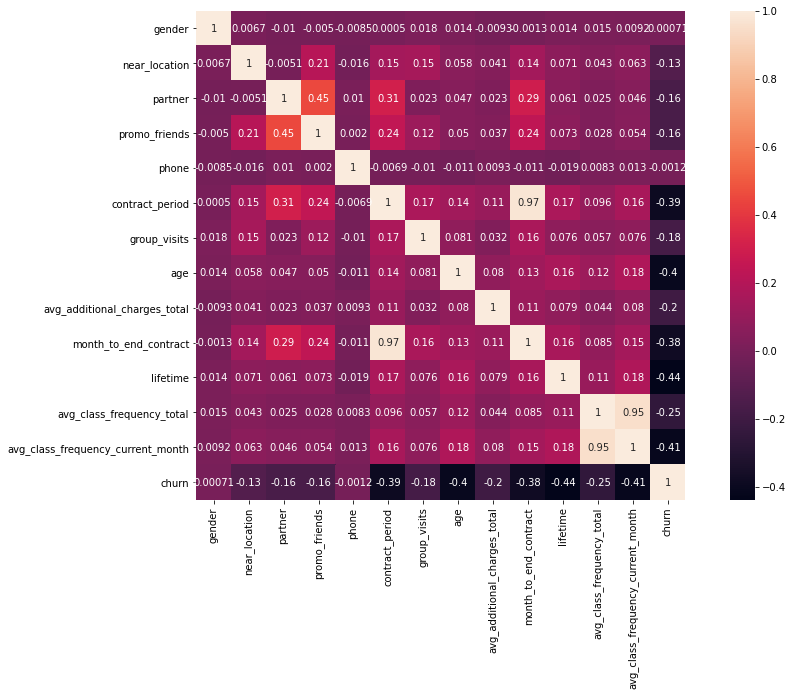

In [10]:
cor_matrix = gym_df.corr()
display(cor_matrix)

plt.figure(figsize=(16, 9))
sns.heatmap(cor_matrix, annot=True, square=True)
plt.show()

По графику видно, что есть несколько признаков, которые сильно коррелируют друг с другом:
- признаки `partner` и `promo_friends` имеют ярко выраженную, хоть и не очень сильную, положительную корреляцию со значением 0.45
- признаки `contract_period` и `month_to_end_contract` сильно коррелируют друг с другом с коэффициентом 0.97
- признаки `avg_class_frequency_current_month` и `avg_class_frequency_total` так же сильно коррелируют с коэффициентом 0.95

По отношению к признаку `churn` не заметно сильно коррелирующих признаков. Наибольшая отрицательная корреляция имеется с признаками `lifetime`, `age`, `contract_period` и `avg_class_frequency_current_month`, с которыми коэффициент корреляции доходит до уровня -0.39.
В таком случае из полученных выше коррелирующих признаков можно оставить те, которые коррелируют с параметрами `churn` - это признаки `contract_period` и `avg_class_frequency_current_month`.

Отдельно изучим признаки `partner` и `promo_friends`.

In [11]:
# определим функция для расчета доли оттока
def share(a):
    return round(100 * sum(a)/a.count(), 2)

gym_df.groupby('partner').agg({'promo_friends': ['count', np.sum, share]})

promo_friends             
                count   sum  share
partner                           
0                2053   216  10.52
1                1947  1018  52.29

Около половины клиентов, пришедших от компаний-партнеров, так же пришли и по акции "приведи друга". Вероятно клиенты пришедшие от компаний-партнеров часто приглашают своих друзей по акции.

Изучим обратное соотношение по тем же признакам.

In [12]:
gym_df.groupby('promo_friends').agg({'partner': ['count', np.sum, share]})

partner             
                count   sum  share
promo_friends                     
0                2766   929  33.59
1                1234  1018  82.50

Видим, что 82% клиентов, пришедших по акции "приведи друга" являются клиентами от компаний-партнеров. При этом мы имеем около 33% клиентов от компаний-партнеров, среди тех, кто не был приглашен по акции "приведи друга".
Соответственно, в данном случае определенно есть некоторая взаимосвязь между признаками, но мы не можем утверждать, что наличие одного признака обязательно влияет на наличие второго, на что и указывает не очень высокий коэффициент корреляции.

Эти признаки можно оставить в датасете.

Сохраним датасет в новую переменную, убрав коррелирующие признаки.

In [13]:
new_gym_df = gym_df.drop(columns=['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

И построим по новому датасету тепловую карту для проверки корреляций.

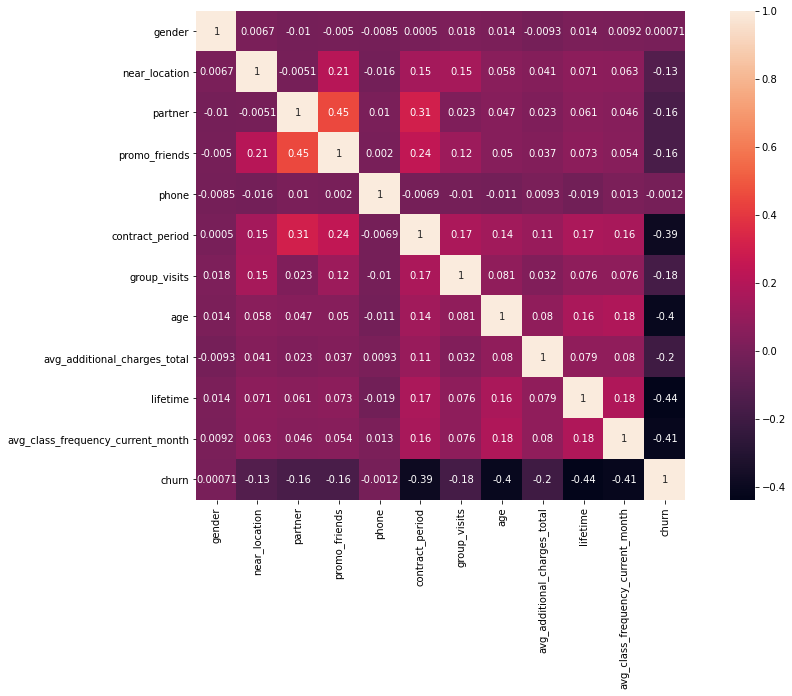

In [14]:
plt.figure(figsize=(16, 9))
sns.heatmap(new_gym_df.corr(), annot=True, square=True)
plt.show()

### Выводы:

Признаки в большей степени указывающие на вероятность оттока:
- близость к дому;
- срок действия абонемента (чем меньше, тем больше вероятность оттока);
- клиенты от партнеров (наименее склонны к оттоку);
- клиенты пришедшие по акции 'приведи друга' (наименее склонны к оттоку);
- возраст клиента (чем моложе - тем вероятнее отток);
- остаточный срок действия абонемента (отток вероятнее для тех, у кого осталось менее 3-х месяцев до истечения абонемента);
- lifetime (клиенты с liftime меньше 10 месяцев более склонны к оттоку);
- количество посещений в неделю (чем  меньше - тем больше вероятность оттока);
- среднее количество посещений в неделю за прошлый месяц (оттсутствие посещений явно указывает на вероятный отток).

## Модель прогнозирования оттока клиентов

Построим модели прогнозирования оттока клиентов с помощщью метода логистической регрессии и метода случайного леса.

In [15]:
# выделим в отдельные переменные признаки и целевой показатель
X = new_gym_df.drop('churn', axis=1)
y = new_gym_df['churn']

In [16]:
# разделим выборки на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
# выведем размеры выборок
splitted_data = [X_train, X_test, y_train, y_test]

for splitted in splitted_data:
    
    print(splitted.shape)

(3200, 11)
(800, 11)
(3200,)
(800,)


Выборки были разбиты на обучающую и тестовую корректно.

In [17]:
# проведем  стандартизацию признаков
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [18]:
# создадим список с моделями
models = [LogisticRegression(solver='liblinear', random_state=0), 
          RandomForestClassifier(n_estimators = 100, random_state=0)]
models_titles = ['Логистическая регрессия', 'Случайный лес']

In [19]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [20]:
# для каждой модели проведем обучение и смоделируем прогнозные значения
for index, model in enumerate(models):
    model.fit(X_train_st, y_train)
    predictions = model.predict(X_test_st)
    
    print_all_metrics(y_test, predictions, title=models_titles[index])

Логистическая регрессия
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
Случайный лес
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75


Обе модели показали себя хорошо, исходя из метрик, но у модели случайного леса метрики оказались чуть лучше.

### Выводы:

Было проведено прогнозирование оттока клиентов с помощью модели логистической регрессии и модели случайного леса.

Наилучшей оказалась модель случайного леса со следующими метриками:
- Accuracy: 0.89
- Precision: 0.78
- Recall: 0.74

## Кластеризация клиентов

Проведем кластеризацию клиентов с помощью модели агломеративной иерархической кластеризации и модели K-средних.

In [21]:
# стандартизируем признаки по клиентам
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

In [22]:
# применим иерархическую кластеризацию
linked = linkage(X_st, method = 'ward') 

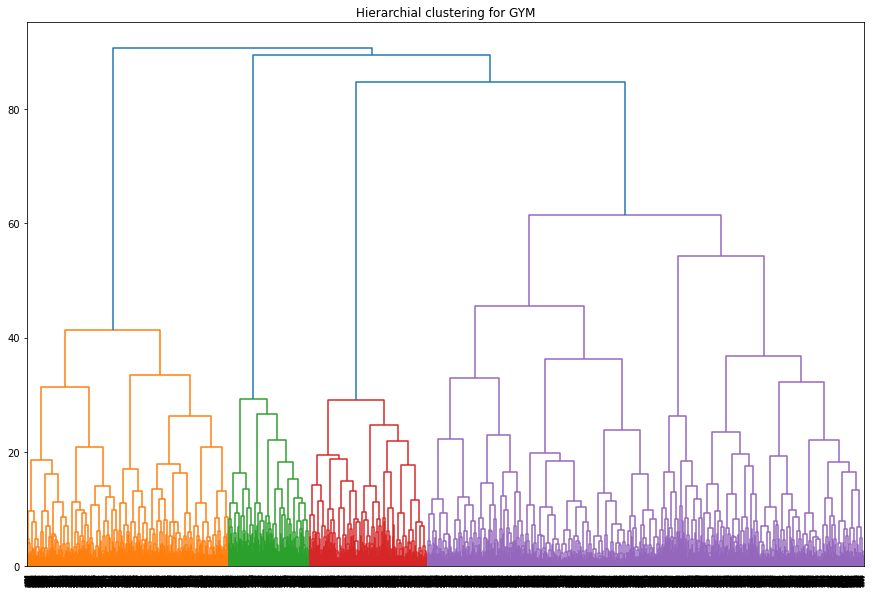

In [23]:
# построим дендрограмму на основе полученной кластеризации
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

На полученной дендрограмме мы можем увидеть 4 ярко выраженных кластера, при этом 4-й кластер можно разделить еще на 2.

Остановимся на количестве кластеров равному 5 и проведем кластеризацию по модели K-средних.

In [24]:
# сохраним  в переменной количество кластеров
n = 5

# создадим объект модели K-средних
km = KMeans(n_clusters=n, random_state=0)

# спрогнозируем кластеры
labels = km.fit_predict(X_st)

# добавим полученные класттеры в таблицу с информацией о клиентах
new_gym_df['cluster'] = labels

In [25]:
# выведем средние значения с разббивкой по кластерам
new_gym_df.groupby('cluster').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


Исходя из средних значений сложно сказать, каким образом были определены кластеры.

Построим графики попарных сравнений признаков.

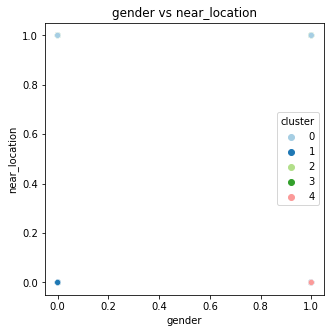

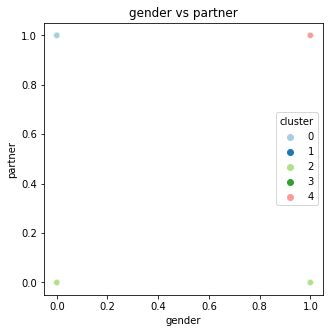

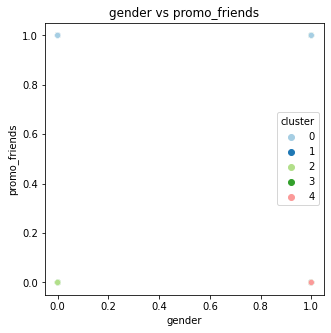

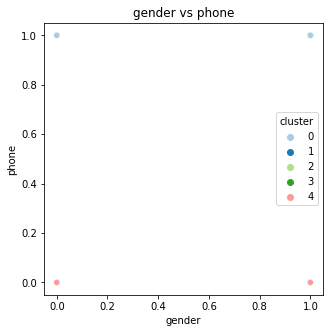

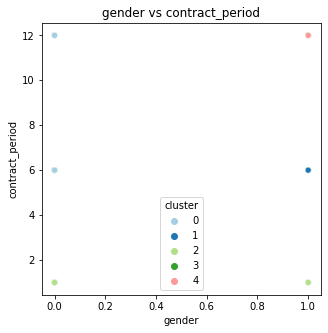

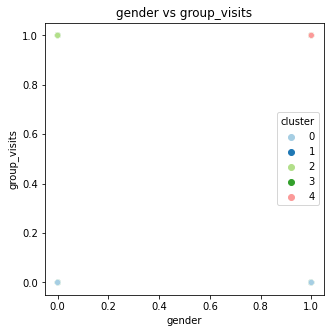

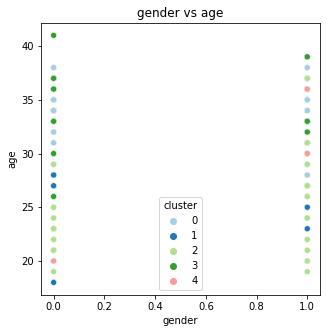

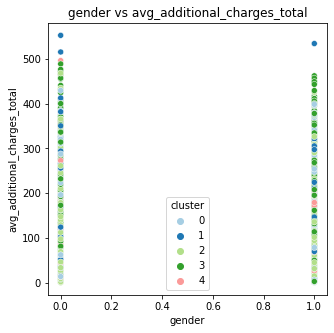

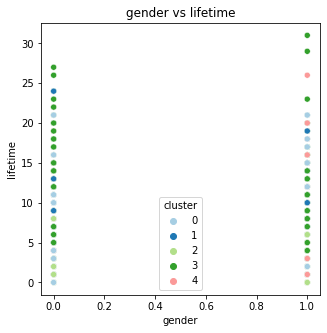

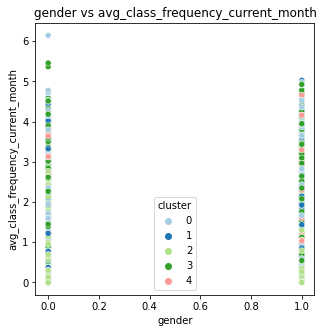

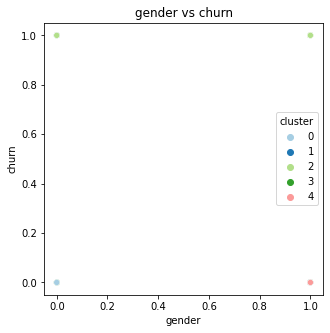

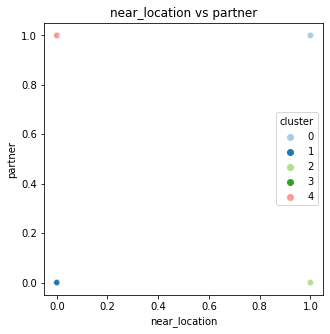

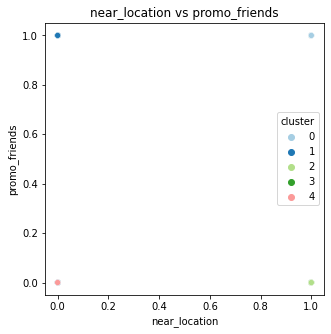

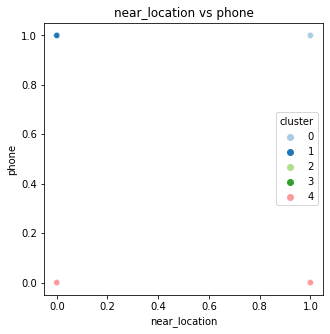

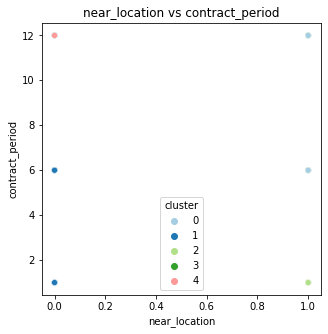

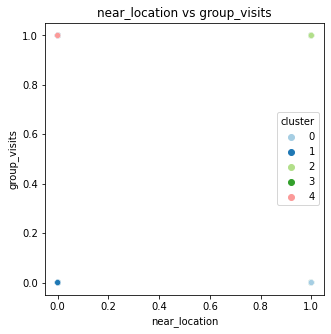

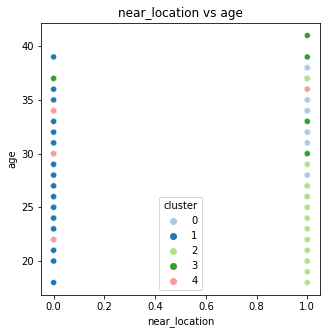

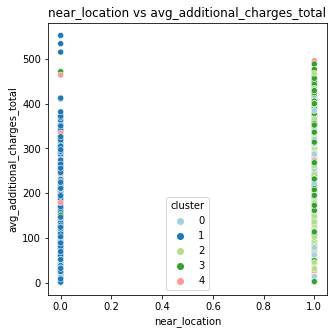

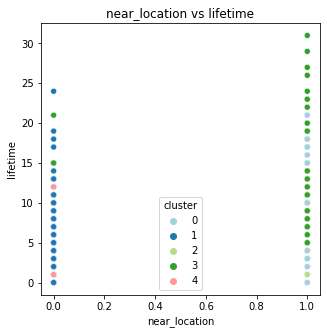

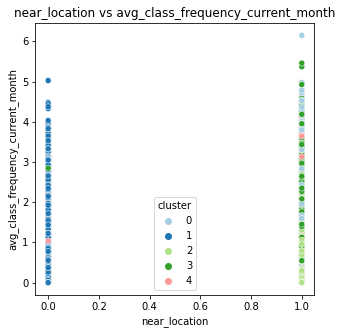

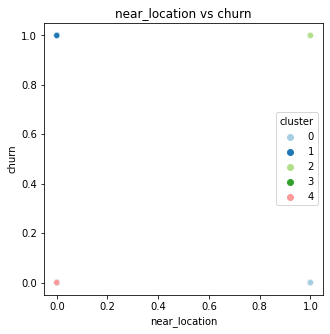

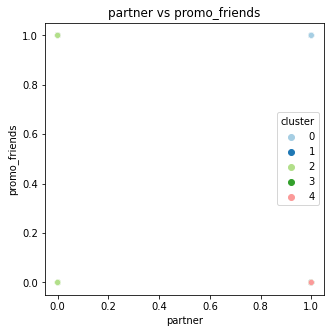

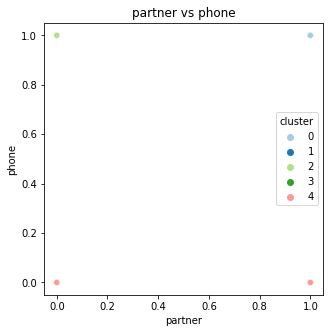

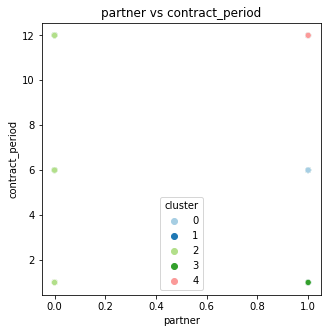

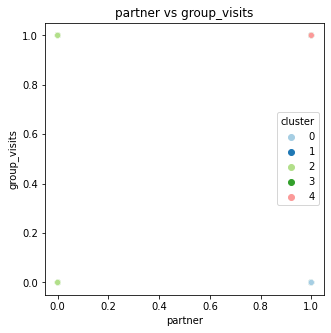

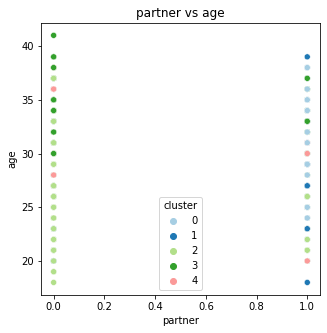

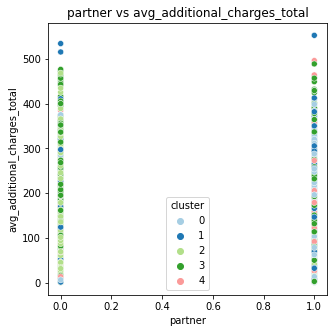

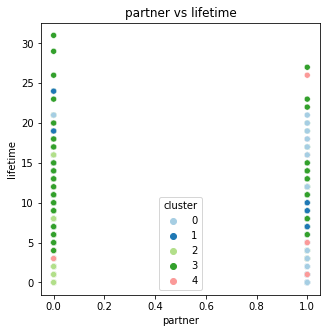

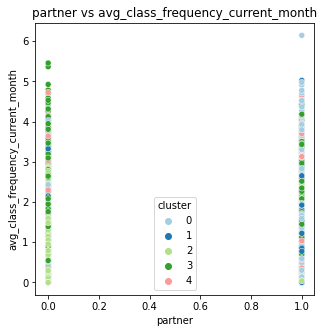

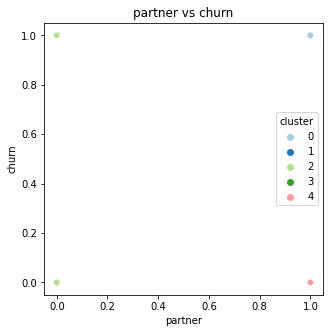

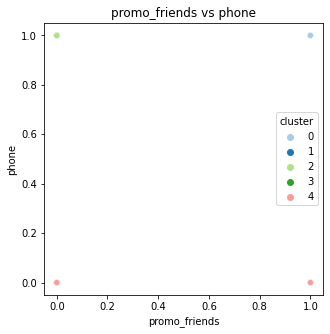

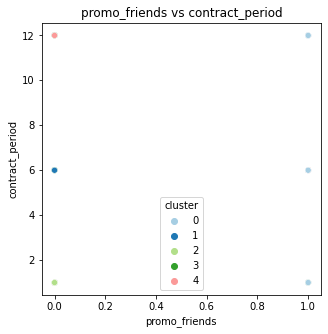

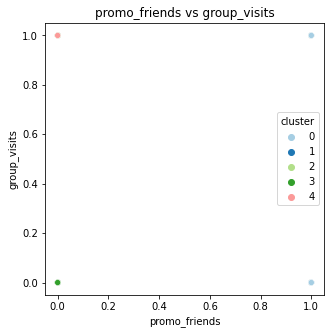

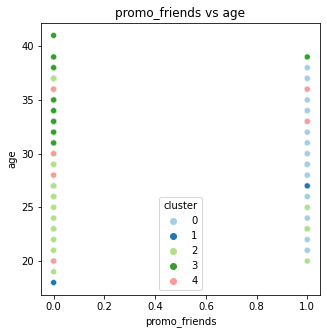

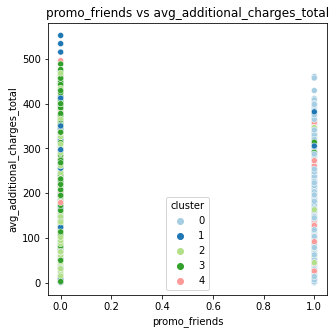

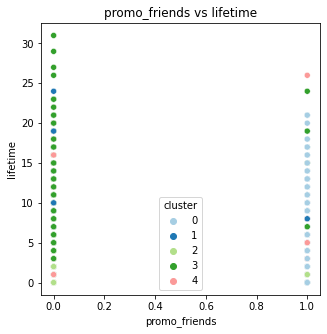

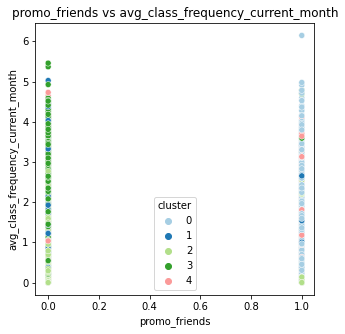

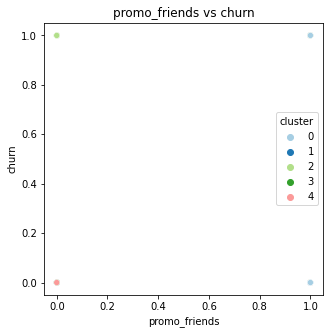

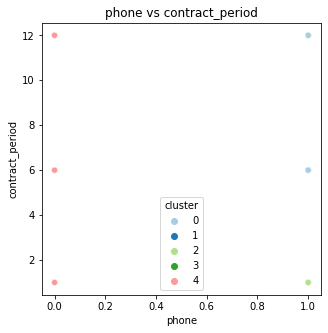

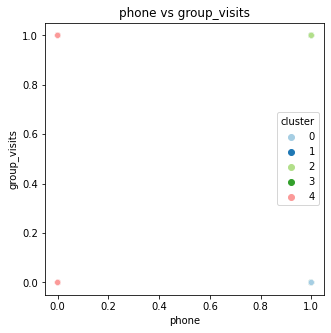

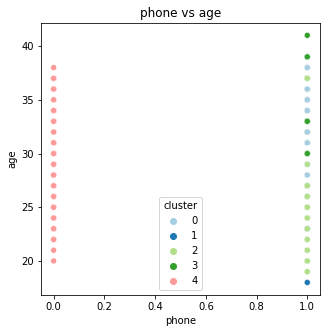

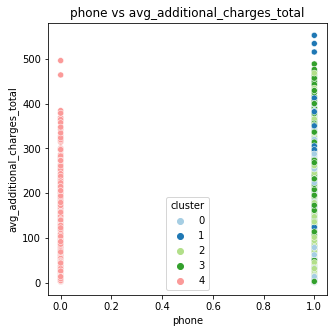

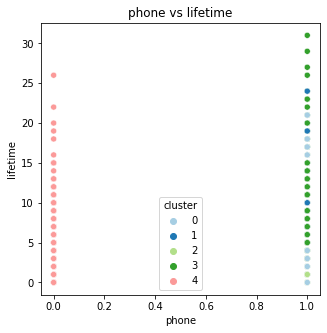

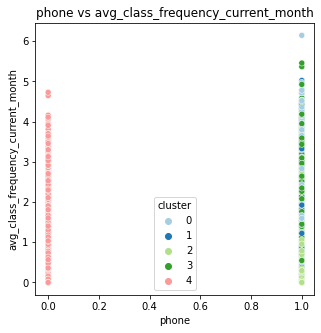

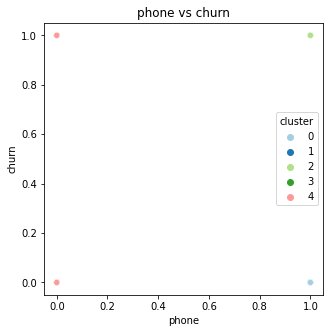

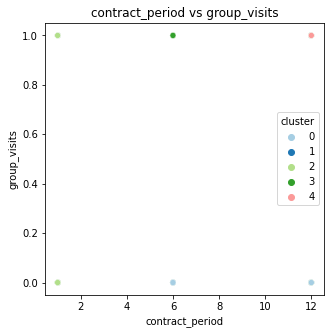

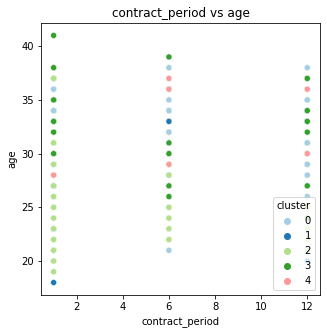

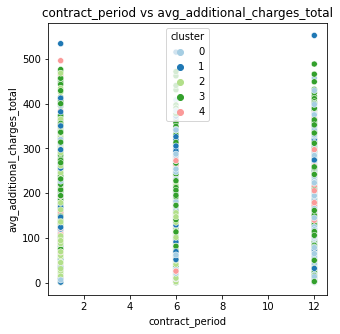

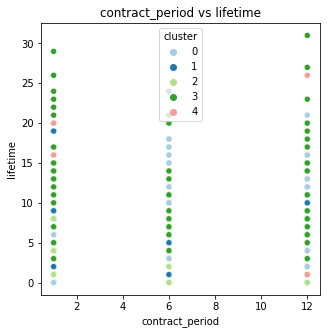

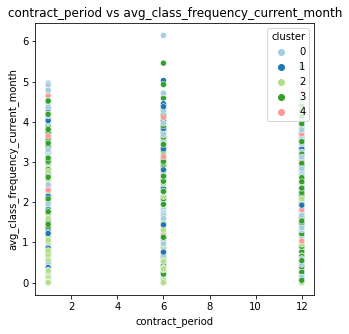

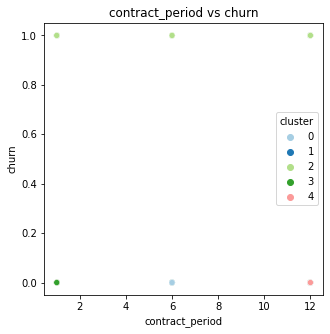

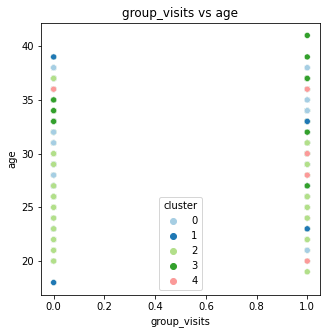

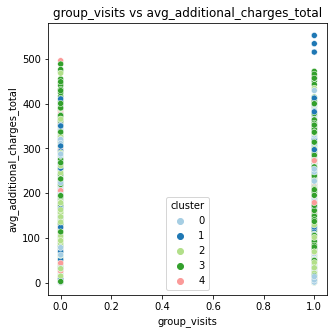

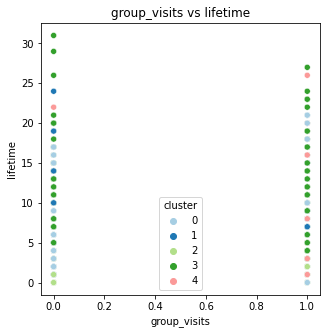

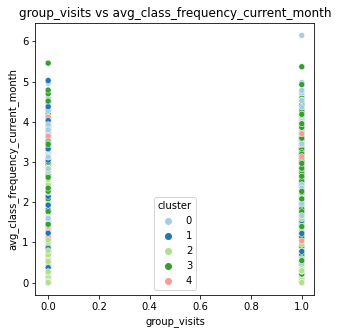

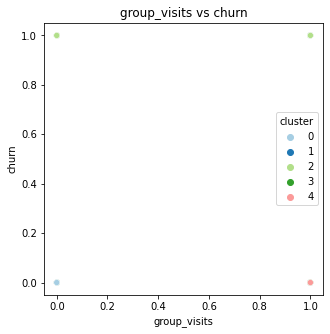

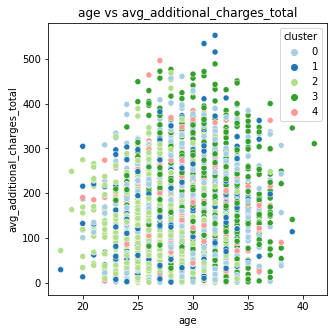

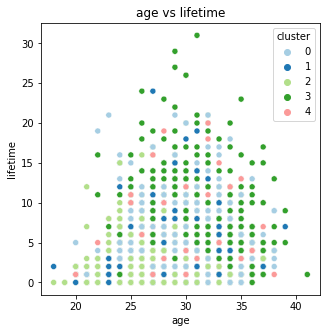

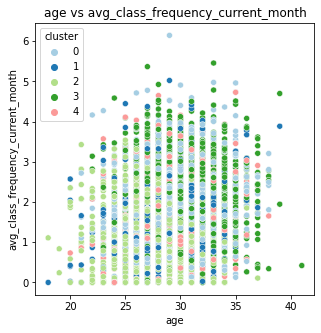

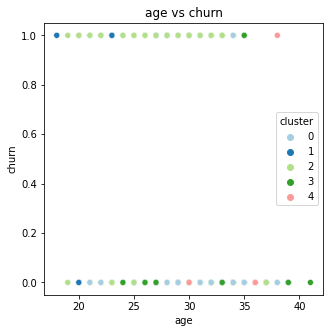

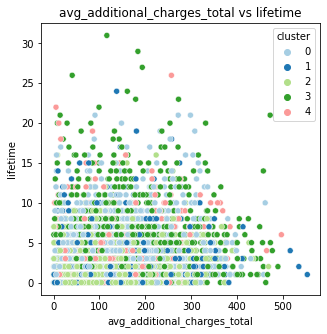

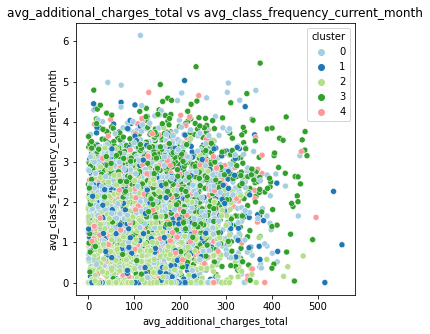

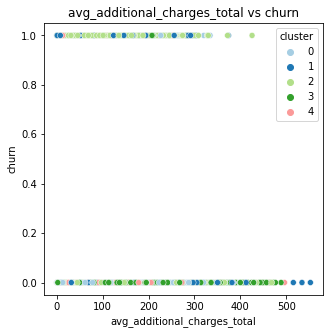

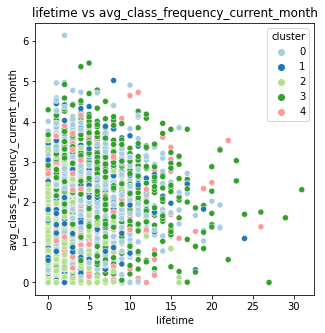

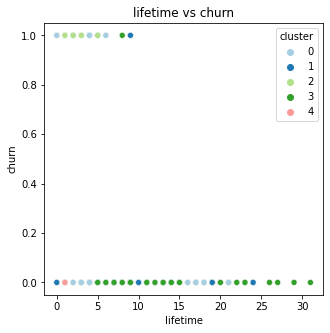

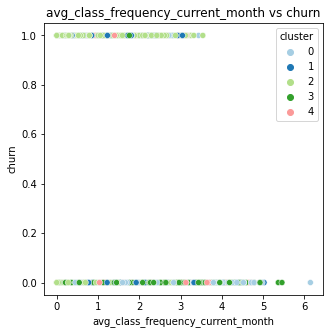

In [26]:
# определим функцию для отрисовки графика
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

# создадим массив с парами колонок таблицы для сравнения
col_pairs = list(itertools.combinations(new_gym_df.drop('cluster', axis=1), 2))

# построим графики попарных сравнений
for pair in col_pairs:
    show_clusters_on_plot(new_gym_df, pair[0], pair[1], 'cluster')

Одним из признаков по которому была проведена кластеризация является признак `phone`. На некоторых графиках заметно, как для значения 0 у данного признака на пересечении оказываются клиенты из кластера 4.

На некоторых графиках по признаку `age` и `lifetime` тоже прослеживается некоторое разделение кластеров.

Посмотрим долю оттока по кластерам.

In [27]:
(
    new_gym_df.groupby('cluster')
    .agg({'churn': ['count', np.sum, share]})
    .sort_values(by=('churn', 'share'), ascending=False)
)

churn            
        count  sum  share
cluster                  
2        1064  600  56.39
1         558  225  40.32
4         386  103  26.68
0         985  118  11.98
3        1007   15   1.49

Доля оттока больше для кластеров `2` и `1`.

### Выводы:

Была проведена иерархическая кластеризация на основе которой мы определили количество кластеров равное 5.

После было проведено прогнозирование кластеров с помощью метода K-средних. На основе полученных кластеров было определено, что вероятнее всего при формировании кластеров учитывались признаки `phone`, `age` и `lifetime`.

Были выявлены кластеры `2` и `1` с долями оттока выше 40%.

## Общие выводы и рекомендации

### Выводы

В ходе исследования были определены признаки в большей степени указывающие на вероятность оттока:
- близость к дому;
- срок действия абонемента (чем меньше, тем больше вероятность оттока);
- клиенты от партнеров (наименее склонны к оттоку);
- клиенты пришедшие по акции 'приведи друга' (наименее склонны к оттоку);
- возраст клиента (чем моложе - тем вероятнее отток);
- остаточный срок действия абонемента (отток вероятнее для тех, у кого осталось менее 3-х месяцев до истечения абонемента);
- lifetime (клиенты с liftime меньше 10 месяцев более склонны к оттоку);
- количество посещений в неделю (чем  меньше - тем больше вероятность оттока);
- среднее количество посещений в неделю за прошлый месяц (отсутствие посещений явно указывает на вероятный отток).

Наилучшей моделью прогнозирования оттока клиентов оказалась модель случайного леса.

При кластеризации клиентов было лпределено 5 кластеров, вероятнее всего сформированных на основе признаков `phone`, `age` и `lifetime`. Также были выявлены кластеры `2` и `1` имеющие набольшую долю оттока клиентов (выше 40%) 

### Рекомендации

В ходе исследования мы получили модели, позволяющие достаточно точно прогнозировать отток клиентов, используя накопленные данные по нему и данные за прошлый месяц. Также с помощью модели мы кластеризировали клиентов и смогли выявить кластеры более склонные к оттоку.

Имея на руках эти инструменты мы можем определять клиентов, которые вероятнее всего в ближайшее время перестанут пользоваться услугами фитнес-центра. Также, мы знаем какие признаки больше всего могут указывать на вероятность оттока.

Используя эти данные можно подготовить несколько сценариев для маркетинговых действий, позволяющих увеличить мотивацию клиента к посещениям при помощи email-рассылок (банальные напоминания и мотивирующие статьи), стимулировать его к посещению с помощью скидок на доп.услуги или же на продление абоненмента, стимулировать к приобретению аонемента с большим сроком действия.

Например, мы знаем, что клиенты, у которых срок действия абонемента истекает через 2 месяца, с высокой долей вероятности попадают в отток. Таким клиентам можно за 2 месяца до окончания абонемента предлагать продление абонемента на более выгодных условиях.